In [1]:
import os
import re
from datetime import datetime, timedelta
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad
from scikeras.wrappers import KerasClassifier
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint

# sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# other
# import tqdm notebook
from tqdm.notebook import tqdm

import multiprocessing as mp

#### Matplotlib settings
%matplotlib inline
import matplotlib as mpl

# specify default rcParams so that fontsize, weight and style don't need to be set each time
# Title in bold, fontsize 20
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlesize'] = 20
# Plot fontsize 16 and bold
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['axes.labelsize'] = 16
# set figure size
mpl.rcParams['figure.figsize'] = (18, 8)
# set grid on
mpl.rcParams['axes.grid'] = True
# set grid linestyle
mpl.rcParams['grid.linestyle'] = '--'
# set axis labels fontsize
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

# race list and colors that will be used to represent them
RACE_LIST = [
    'Protoss',
    'Terran',
    'Zerg'
    ]
COLOR_DICT = {
    'Protoss': 'goldenrod',
    'Terran': 'firebrick',
    'Zerg': 'darkviolet'
    }

#### Pandas options
# these are set to allow better exploration of the large dataframes in this 
# notebook
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

#IPython
from IPython.display import display
%load_ext autoreload


In [2]:
class BatchGenerator(keras.utils.Sequence):
    
    def __init__(
        self, 
        list_filehashes, 
        labels,
        data_dir,
        window_size,
        n_channels,
        window_start=0,
        batch_size=32,  
        n_classes=2, 
        shuffle=True
    ):
        """
        Generate batches of data for training.
    
        Args:
            data (str): the path to a directory of npy files
            labels (dict): a dictionary of filehashes and their corresponding labels
            list_filehashes (list): the list of filehashes to use
            window_size (int): the number of timesteps to use as a window
            n_channels (int): the number of features in the data
            batch_size (int): the number of samples per batch. Defaults to 32.
            n_classes (int): the number of classes for the target. Defaults to 2.
            shuffle (bool): whether to shuffle the data. Defaults to True.
        """
        self.data_dir = data_dir
        self.labels = labels
        self.batch_size = batch_size
        self.window_size = window_size
        self.window_start = window_start
        self.n_channels = n_channels
        self.list_IDs = list_filehashes
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' 
        # X : (n_samples, window_size, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.window_size, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):

            # get X_tmp and then cut down to the window size
            X_tmp = np.load(os.path.join(self.data_dir, ID + '.npy'))

            X[i,] = X_tmp[
                self.window_start:self.window_start + self.window_size,
                :
            ]

            # Store class
            y[i] = self.labels[ID]

        return X, y

In [13]:
def create_labels(metadata_df):

    # construct the labels dictionary
    labels = metadata_df[['game_winner', 'filehash']].set_index('filehash').to_dict()['game_winner']
    # drop all keys with value == 0
    labels = {k: v for k, v in labels.items() if v != 0}
    # convert value all keys with value == 2 to 1
    labels = {k: 0 if v == 2 else 1 for k, v in labels.items()}

    return labels

In [3]:
def setup_data_for_modeling(
    metadata_path='data/spawningtool_replays.csv',
    master_columns_path='info/clean_master_columns_list.csv',
    non_feature_columns=['winner', 'filehash', 'frame'],
    partition_index=None,
    window_size=60,
    window_start=0,
    verbose=True
):
    """
    Setup the data for modeling.
    
    Args:
        metadata_path (str): the path to the metadata csv. Defaults to 'data/spawningtool_replays.csv'.
        master_columns_path (str): the path to the master_columns_list csv. Defaults to 'info/clean_master_columns_list.csv'.
        non_feature_columns (list): the list of non-feature columns. Defaults to ['winner', 'filehash', 'frame'].
        window_size (int): the window size to use. Defaults to 60.
        verbose (bool): whether to print out the progress. Defaults to True.

    Returns tuple:
        panda.DataFrame: the dataframe containing the metadata
        list: the list of all columns
        list: the list of feature columns
        dict: the dictionary of train, val, and test filehashes
        dict: the dictionary of labels
    """
    # get spawningtool_df
    spawningtool_df = pd.read_csv(metadata_path)

    # get master_columns_list
    master_columns_list = pd.read_csv(master_columns_path).values.tolist()
    master_columns_list = [col[0] for col in master_columns_list]

    # create non_feature_columns
    non_feature_columns = ['winner', 'filehash', 'frame']
    # create feature_columns list
    feature_columns = [
        col for col in master_columns_list if col not in non_feature_columns
    ]

    partition = {}

    if partition_index is None:
        # loop through files in the partitions and create a list of hashes that meet 
        # the window size
        
        for folder in ['train', 'val', 'test']:
            # get the filenames in the folder
            filehashes = [
                os.path.splitext(f)[0] for f in os.listdir(
                    f'data/model_data/{folder}'
                )
            ]

            partition_list = []
            # load the file and check its shape[0]
            for filehash in filehashes:
                arr = np.load(f'data/model_data/{folder}/{filehash}.npy')
                if arr.shape[0] > (window_size + window_start):
                    partition_list.append(filehash)

            # add the filehashes to the partition
            partition[folder] = partition_list

            # calculate number of files removed
            removed = len(filehashes) - len(partition_list)

            if verbose:
                print(f'\t{folder} has {len(filehashes)} valid files, removed {removed} files ({round(100*removed/len(filehashes),2)}%)')

    else:
        for folder in partition_index['partition'].unique():
            # filter by shape > window_size + window_start
            mask = (partition_index['partition'] == folder) \
                & (partition_index['shape'] > (window_size + window_start)) 

            # get the filehashes
            partition[folder] = partition_index.loc[mask].index.values.tolist()


    # get labels
    labels = create_labels(spawningtool_df)

    return spawningtool_df, master_columns_list, feature_columns, partition, labels

In [4]:
# function to create, train, evaluate, and save a model for a given window size
def train_evaluate_model(
    window_size,
    partition_index,
    window_start=0,  
    save_models=True,
    verbose=1
):
    """
    train_evaluate_model
    Train, evaluate, and save a model for a given window size.

    Args:
        window_size (int): the window size to use
        partition_index (panda.DataFrame): the dataframe containing the partition index
        window_start (int): the window start to use. Defaults to 0.
        save_models (bool): whether to save the models to file or not
        verbose (int): the verbosity level for Keras. Defaults to 1.

    Returns:
        tuple: model, history, model_file, score, prediction_results
    """

    print('\tSetting up model data...')
    # setup the model
    # set up the data for modeling
    _, _, feature_columns, partition, labels = setup_data_for_modeling(
        window_size=window_size, 
        window_start=window_start,
        partition_index=partition_index,
    )

    # create a dictionary of parameters to pass to both generators
    params = {
        'window_size': window_size, 
        'window_start': window_start,
        'n_channels': len(feature_columns),
        'batch_size': 32, 
        'shuffle': True
    }

    # setup generators for training and validation
    training_generator = BatchGenerator(
        partition['train'],
        labels,
        data_dir='data/model_data/train',
        **params
    )

    validation_generator = BatchGenerator(
        partition['val'],
        labels,
        data_dir='data/model_data/val',
        **params
    )

    print('\tCreating model architecture...')
    # instantiate RNN model
    model = Sequential()

    # add LSTM layer
    model.add(LSTM(
        units=128,
        input_shape=(window_size, len(feature_columns)),
        return_sequences=False
    ))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # add dense layer
    model.add(Dense(
        1, 
        activation='sigmoid', 
        kernel_regularizer=keras.regularizers.l1(0.01)
    ))

    # compile model using binary crossentropy loss and adam optimizer
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    # generate a unique identifier for the model use LSTM nodes and window_size
    model_file = f'models/lstm_size.{window_size}_from.{window_start}'
    model_file_ext = '.h5'
    # check if the model file exists and if so, append a version number
    if os.path.exists(model_file+model_file_ext):
        # iterate through the version number to find the next available version number
        i = 1
        model_file = model_file.split('_v')[0] + '_v' + str(i)
        while os.path.exists(model_file+model_file_ext):
            i += 1
            model_file = model_file + '_v' + str(i)

    # create a callback to log history
    csv_logger = CSVLogger(model_file+'.csv')

    # create a callback to save checkpoints
    checkpoint = ModelCheckpoint(
        filepath='models/checkpoints/'+model_file.split('/')[1]+'.hdf5',
        monitor='val_loss',
        verbose=0,
        save_best_only=False
    )

    # create a callback which stops training when no improvement is being made
    earlystop = EarlyStopping(
        monitor='val_loss', # monitor validation loss to prevent overfitting
        patience=2, # stop after 3 epochs without improvement
        verbose=1,  # print a message when the callback is triggered
        mode='auto' # keras infers if the monitored variable should be increasing or decreasing
    )

    # set up callbacks to be used for training
    if save_models:
        callbacks = [earlystop, csv_logger, checkpoint]
    else:
        callbacks = [earlystop]

    print('\tTraining model...')
    # fit the model and save to history
    history = model.fit(
        training_generator,
        validation_data=validation_generator,
        epochs=50,
        callbacks=callbacks,
        verbose=verbose
    )

    if save_models:   
        # pickle the model
        model.save(model_file+model_file_ext)

    # get the last value for val_accuracy
    score = history.history['val_accuracy'][-1]

    print('\tGenerating predictions...')
    # create a generator for predictions
    prediction_generator = BatchGenerator(
        partition['val'],
        labels,
        data_dir='data/model_data/val',
        window_size=window_size,
        window_start=window_start, 
        n_channels=len(feature_columns),
        batch_size=1, 
        shuffle=False
    )

    # make predictions
    predictions = model.predict(prediction_generator)

    # get the true labels for the predictions
    true_labels = [labels[k] for k in partition['val']]

    # create the prediction_results dataframe
    prediction_results = pd.DataFrame({
        'filehash': partition['val'],
        'probability': predictions.reshape(-1),
    })

    # set the filehash as the index
    prediction_results.set_index('filehash', inplace=True)

    # return the model and the score
    return model, history, model_file, score, prediction_results

In [5]:
def create_partitions():
    
    folder_list = [
        'data/model_data/train',
        'data/model_data/val',
        'data/model_data/test'
    ]

    partition_index = pd.DataFrame(columns=['filehash', 'shape'])

    for folder in folder_list:
        for file in os.listdir(folder):
            filehash = os.path.splitext(file)[0]
            partition_index = partition_index.append(
                {
                    'filehash': filehash,
                    'shape': int(
                        np.load(folder+'/'+file, mmap_mode='r').shape[0]),
                    'partition': folder.split('/')[-1]
                },
                ignore_index=True
            )

    partition_index.set_index('filehash', inplace=True)

    print('Partitioning complete.')

    return partition_index

In [6]:
model_dict = {}
i = 0
print('Partitioning data...')
partition_index = create_partitions()
print('-'*80)

# create a list of window sizes and start tuples
model_params = []
for window_size in np.arange(48, 121, 6):
    for window_start in np.arange(0, 121 - window_size, step=1):
        model_params.append((window_size, window_start))

for i in tqdm(range(len(model_params)), 
    desc='Training models',
    unit='model'
):
    # get the window size and start tuple
    window_size, window_start = model_params[i]

    # set up the model
    model, history, model_file, score, new_pred_results = train_evaluate_model(
        window_size=window_size,
        window_start=window_start,
        save_models=False,
        partition_index=partition_index,
        verbose=0
    )

    model_index = str(window_start)+'_'+str(window_size)

    new_pred_results.rename(
        columns={'probability': model_index},
        inplace=True
    )

    if i == 0:
        prediction_results = new_pred_results
    else:
        prediction_results = pd.concat(
            [prediction_results, new_pred_results], 
            axis=1
        )

    # save models in a dict keyed by window_start + window_size
    model_dict[model_index] = model
    print('Done!')
    print('-'*80)

Partitioning data...
Partitioning complete.
--------------------------------------------------------------------------------


Training models:   0%|          | 0/481 [00:00<?, ?model/s]

	Setting up model data...
	Creating model architecture...
	Training model...
Epoch 00008: early stopping
	Generating predictions...
Done!
--------------------------------------------------------------------------------
	Setting up model data...
	Creating model architecture...
	Training model...
Epoch 00009: early stopping
	Generating predictions...
Done!
--------------------------------------------------------------------------------
	Setting up model data...
	Creating model architecture...
	Training model...
Epoch 00008: early stopping
	Generating predictions...
Done!
--------------------------------------------------------------------------------
	Setting up model data...
	Creating model architecture...
	Training model...
Epoch 00006: early stopping
	Generating predictions...
Done!
--------------------------------------------------------------------------------
	Setting up model data...
	Creating model architecture...
	Training model...
Epoch 00007: early stopping
	Generating predict

In [9]:
# loop through each model and save the model
count = 0
for model_index in model_dict.keys():
    model = model_dict[model_index]
    model.save('models/ensemble/'+model_index+'_'+str(count)+'.h5')

In [10]:
# sort columns 
prediction_results.head()

,0_48,1_48,2_48,3_48,4_48,5_48,6_48,7_48,8_48,9_48,10_48,11_48,12_48,13_48,14_48,15_48,16_48,17_48,18_48,19_48,20_48,21_48,22_48,23_48,24_48,25_48,26_48,27_48,28_48,29_48,30_48,31_48,32_48,33_48,34_48,35_48,36_48,37_48,38_48,39_48,40_48,41_48,42_48,43_48,44_48,45_48,46_48,47_48,48_48,49_48,50_48,51_48,52_48,53_48,54_48,55_48,56_48,57_48,58_48,59_48,60_48,61_48,62_48,63_48,64_48,65_48,66_48,67_48,68_48,69_48,70_48,71_48,72_48,0_54,1_54,2_54,3_54,4_54,5_54,6_54,7_54,8_54,9_54,10_54,11_54,12_54,13_54,14_54,15_54,16_54,17_54,18_54,19_54,20_54,21_54,22_54,23_54,24_54,25_54,26_54,...,33_84,34_84,35_84,36_84,0_90,1_90,2_90,3_90,4_90,5_90,6_90,7_90,8_90,9_90,10_90,11_90,12_90,13_90,14_90,15_90,16_90,17_90,18_90,19_90,20_90,21_90,22_90,23_90,24_90,25_90,26_90,27_90,28_90,29_90,30_90,0_96,1_96,2_96,3_96,4_96,5_96,6_96,7_96,8_96,9_96,10_96,11_96,12_96,13_96,14_96,15_96,16_96,17_96,18_96,19_96,20_96,21_96,22_96,23_96,24_96,0_102,1_102,2_102,3_102,4_102,5_102,6_102,7_102,8_102,9_102,10_102,11_102,12_102,13_102,14_102,15_102,16_102,17_102,18_102,0_108,1_108,2_108,3_108,4_108,5_108,6_108,7_108,8_108,9_108,10_108,11_108,12_108,0_114,1_114,2_114,3_114,4_114,5_114,6_114,0_120
filehash,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0016ddd5b36473f259ba8630c6c0047540a6858071737e8f890358d3f7ad355d,0.029698,0.080832,0.049923,0.118166,0.223824,0.177816,0.045554,0.106425,0.194602,0.048929,0.061413,0.047669,0.088884,0.206801,0.064651,0.275370,0.151547,0.077658,0.029862,0.041826,0.051233,0.011541,0.049218,0.089420,0.022117,0.013123,0.030460,0.013854,0.183592,0.064270,0.283902,0.078608,0.084389,0.008901,0.031846,0.214726,0.013098,0.327583,0.740116,0.506495,0.331147,0.346144,0.167521,0.276274,0.395539,0.860666,0.751504,0.311051,0.804861,0.598100,0.753049,0.142164,0.060092,0.031496,0.560822,0.885624,0.319505,0.479512,0.493804,0.150953,0.022642,0.618027,0.570352,0.170242,0.271364,0.845575,0.094429,0.559305,0.352102,0.923105,0.621745,0.295658,0.145317,0.052655,0.125262,0.296246,0.158113,0.260551,0.172064,0.261298,0.182585,0.107669,0.137240,0.360731,0.112294,0.012958,0.013463,0.055620,0.005191,0.103964,0.058726,0.020764,0.009628,0.024620,0.109718,0.467515,0.022748,0.094592,0.035569,0.520413,...,0.494885,0.551332,0.894536,0.101025,0.085483,0.204991,0.740870,0.647179,0.394482,0.303274,0.893054,0.264133,0.273751,0.057169,0.138298,0.220179,0.605863,0.527785,0.706976,0.273590,0.363384,0.744208,0.128260,0.798777,0.098031,0.288894,0.065271,0.651618,0.943892,0.758336,0.699642,0.156586,0.336604,0.060895,0.469109,0.481473,0.316594,0.207696,0.245382,0.449606,0.220301,0.559647,0.556434,0.724366,0.327392,0.737083,0.367128,0.221972,0.841491,0.041223,0.837291,0.008387,0.633813,0.318139,0.024553,0.163532,0.089204,0.026484,0.137825,0.041519,0.250772,0.436267,0.308587,0.481186,0.482252,0.368783,0.330872,0.637380,0.630386,0.452975,0.618075,0.540244,0.727182,0.165879,0.576970,0.032162,0.121999,0.176663,0.097464,0.130436,0.714333,0.175717,0.739042,0.020250,0.485943,0.401508,0.636606,0.870755,0.282143,0.194977,0.077225,0.023264,0.804053,0.802499,0.432499,0.559297,0.016355,0.094903,0.114713,0.206466
00283dcee1b0bec45ff654a0df06248d9f69a5c3a66e7827e10660ad88bf5bee,0.295901,0.616100,0.585490,0.763552,0.874480,0.942619,0.703923,0.629009,0.812236,0.865754,0.784470,0.449863,0.337121,0.661061,0.956659,0.866433,0.686306,0.927653,0.934034,0.947765,0.808483,0.833280,0.770048,0.862283,0.960639,0.920410,0.881784,0.942431,0.725764,0.811090,0.913210,0.927040,0.346670,0.804140,0.554704,0.771561,0.360767,0.902478,0.600150,0.942712,0.617142,0.657846,0.777856,0.892649,0.845431,0.937457,0.516100,0.339713,0.418890,0.245681,0.449455,0.308119,0.552498,0.709674,0.107609,0.854450,0.504910,0.444506,0.328661,0.489310,0.256028,0.322243,0.130332,0.021160,0.318908,0.374743,0.091339,0.308014,0.311482,0.105572,0.245726,0.194622,0.853658,0.634948,0.893021,0.74

In [14]:
# read in the metadata
spawningtool_df = pd.read_csv('data/spawningtool_replays.csv')

# get the labels
labels = create_labels(spawningtool_df)

In [15]:
def aggregate_predictions(predictions, metadata):
    # loop through each col in prediction results and get a dict of index to sum
    prob_index_dict = {}
    for col in predictions.columns:
        # calculate the row at which the window ends
        end_frame = int(col.split('_')[0]) + int(col.split('_')[1])
        
        # if the end frame is not in the dict, add it
        if end_frame not in prob_index_dict.keys():
            prob_index_dict[end_frame] = [col]
        else:
            prob_index_dict[end_frame].append(col)


    agg_predictions = pd.DataFrame()
    # loop through each key in the dict and get the mean of the values
    for end_frame in prob_index_dict.keys():
        # calculate the row-wise mean of the values in these columns and add to the dataframe
        agg_prob = predictions.loc[:, prob_index_dict[end_frame]].mean(axis=1)
        
        # add the mean as a column to the dataframe
        agg_predictions[end_frame] = agg_prob

    # sort columns in ascending order
    agg_predictions = agg_predictions.reindex(
        sorted(agg_predictions.columns),
        axis=1
    )

    # append game_winner to the dataframe
    agg_predictions['winner'] = pd.DataFrame().from_dict(labels, orient='index')

    # append game length to the dataframe
    agg_predictions['length'] = metadata.set_index('filehash')['game_length']/5

    return agg_predictions

agg_predictions = aggregate_predictions(prediction_results, spawningtool_df)

agg_predictions.head()


,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,winner,length
filehash,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0016ddd5b36473f259ba8630c6c0047540a6858071737e8f890358d3f7ad355d,0.029698,0.080832,0.049923,0.118166,0.223824,0.177816,0.049105,0.115844,0.245424,0.103521,0.160982,0.109867,0.189026,0.170682,0.089482,0.184983,0.259445,0.117815,0.027187,0.032933,0.044005,0.011349,0.046533,0.070703,0.024941,0.022455,0.029916,0.040424,0.224837,0.062168,0.141769,0.212538,0.139552,0.019185,0.147976,0.067908,0.075190,0.331753,0.708202,0.202371,0.288190,0.394197,0.117126,0.412181,0.543048,0.634000,0.587407,0.256679,0.734369,0.640322,0.439475,0.184596,0.140991,0.148540,0.543569,0.567708,0.661769,0.381437,0.415634,0.366015,0.301227,0.725185,0.409948,0.529443,0.245262,0.498787,0.577625,0.498656,0.491801,0.317357,0.196038,0.296253,0.211617,0,161.2
00283dcee1b0bec45ff654a0df06248d9f69a5c3a66e7827e10660ad88bf5bee,0.295901,0.616100,0.585490,0.763552,0.874480,0.942619,0.669436,0.761015,0.780740,0.830931,0.727104,0.502022,0.452369,0.415986,0.937942,0.897614,0.818862,0.907613,0.867234,0.850644,0.780323,0.793507,0.883239,0.890958,0.809717,0.923362,0.632340,0.882474,0.871142,0.917342,0.860490,0.872128,0.701284,0.727705,0.736100,0.632429,0.410252,0.742076,0.761465,0.723962,0.601294,0.647466,0.433692,0.549625,0.630394,0.847661,0.676614,0.515724,0.395499,0.573178,0.545287,0.363934,0.389985,0.591466,0.226051,0.464468,0.534707,0.401697,0.424739,0.504880,0.414498,0.333180,0.191836,0.216881,0.304967,0.250442,0.154725,0.221425,0.303488,0.252059,0.258118,0.325752,0.351423,0,178.2
0033334e86cb352b0131027e58effa23adb23cf1cdd90d5760cc62254611c99a,0.688192,0.856472,0.740203,0.928254,0.940908,0.941489,0.915362,0.925206,0.934794,0.968276,0.900090,0.950041,0.979137,0.937121,0.930140,0.918943,0.949939,0.938874,0.943798,0.951096,0.826471,0.914995,0.889222,0.913643,0.910013,0.822716,0.902883,0.926848,0.795082,0.777135,0.872945,0.733354,0.857619,0.900528,0.869856,0.940228,0.932453,0.961672,0.549144,0.761709,0.613517,0.657306,0.775918,0.829999,0.944010,0.686689,0.959113,0.884538,0.642170,0.843438,0.711400,0.754922,0.828797,0.842460,0.787398,0.600437,0.844334,0.792091,0.816067,0.901142,0.837865,0.705645,0.779353,0.681035,0.570873,0.747662,0.742645,0.679350,0.696317,0.789129,0.540936,0.661435,0.849607,1,214.6
0055f4541fe30a72e964fc168db7abef35822d27e4cdce8ef0adb8b3cba51b7d,0.910836,0.928538,0.527132,0.888624,0.915498,0.909505,0.927731,0.967149,0.935455,0.984202,0.956968,0.980697,0.987332,0.939530,0.952741,0.953666,0.946691,0.956564,0.917624,0.982332,0.945112,0.966749,0.957718,0.879283,0.942988,0.981035,0.961570,0.974043,0.988248,0.992702,0.977239,0.951895,0.964291,0.984865,0.988028,0.986600,0.984741,0.990989,0.964949,0.992553,0.981271,0.984607,0.987333,0.986069,0.981104,0.987983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,94.2
005ac860a39ec7ae855a22b68f13ea17c1d7006bafe381e46cd9f2cbf3fa3a99,0.847571,0.963856,0.809928,0.791543,0.949490,0.851008,0.953126,0.967563,0.956630,0.971145,0.938852,0.944714,0.977624,0.977813,0.957068,0.957609,0.987875,0.970643,0.975519,0.968132,0.940672,0.966959,0.988862,0.956328,0.983833,0.986910,0.983948,0.980048,0.924302,0.977331,0.920068,0.951111,0.968223,0.956626,0.960833,0.968167,0.980781,0.985699,0.990506,0.989244,0.972191,0.989290,0.958299,0.984030,0.995166,0.991015,0.985913,0.951528,0.966056,0.964792,0.977254,0.976929,0.982447,0.713689,0.861239,0.932462,0.941604,0.952223,0.964997,0.968056,0.968781,0.961734,0.974157,0.968409,0.978671,0.987025,0.977041,0.980725,0.979807,0.981203,0.982252,0.993341,0.993303,1,126.4


In [49]:
agg_predictions.drop(columns=['winner', 'length']).loc[game_hash].values

array([0.7633699 , 0.7372874 , 0.37481397, 0.28510046, 0.61181474,
       0.825375  , 0.31476364, 0.31972808, 0.22428766, 0.3435039 ,
       0.37225485, 0.6057095 , 0.6381684 , 0.42742038, 0.45988026,
       0.36916852, 0.49774107, 0.34848297, 0.6333327 , 0.793322  ,
       0.7194455 , 0.75525856, 0.821038  , 0.6036366 , 0.4731819 ,
       0.4419209 , 0.49901134, 0.33664095, 0.6101788 , 0.46319962,
       0.18749762, 0.13039787, 0.1610338 , 0.11424755, 0.06664199,
       0.06557623, 0.24670045, 0.25098208, 0.0790699 , 0.1621588 ,
       0.2866229 , 0.29493645, 0.38711393, 0.17443529, 0.05348754,
       0.1294706 , 0.17898266, 0.2165153 , 0.1295036 , 0.14634909,
       0.02838423, 0.1397459 , 0.16743451, 0.12015149, 0.03842833,
       0.01219733, 0.00991571, 0.03444169, 0.0140866 , 0.00928502,
       0.01122712, 0.02539749, 0.03498638, 0.02168916, 0.03397271,
       0.01436423, 0.05187571, 0.03283773, 0.13080224, 0.0625976 ,
       0.03246713, 0.03219239, 0.05170704], dtype=float32)

In [32]:
agg_predictions.drop(columns=['winner', 'length']).loc[game_hash].index

Index([ 48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120],
      dtype='object')

Predicting:   0%|          | 0/481 [00:00<?, ?model/s]

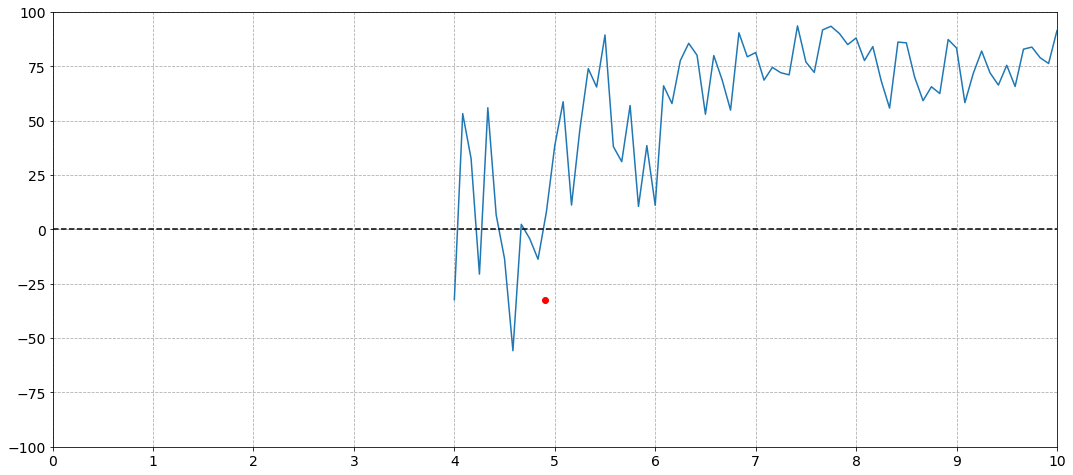

In [134]:
# function to load clean_events, generate predictions and return the predictions
def predict_game(game_hash, model_dict):
    
    # data directory
    data_dir = 'data/model_data/'

    # locate the filename containing game_hash in data_dir
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if game_hash in file:
                filename = root+'/'+file
                break

    # load the data
    data = np.load(filename)

    new_predictions = {}
    # loop through each model and get the prediction
    for key, model in tqdm(
        model_dict.items(), 
        desc='Predicting',
        unit='model'
    ):

        # create a window from the data
        window_start = int(key.split('_')[0])
        window_size = int(key.split('_')[1])
        windowed_data = data[window_start:window_start+window_size]        

        # reshape the windowed data
        windowed_data = windowed_data.reshape(1, window_size, windowed_data.shape[1])

        # add the prediction to the prediction_results
        new_predictions[key] = model.predict(windowed_data)[0]
        
        # convert the dict to a df with index of game_hash
        results_df = pd.DataFrame.from_dict(new_predictions, orient='columns')
        results_df.index = [game_hash]

        # aggregate_predictions
        agg_results = aggregate_predictions(results_df, spawningtool_df)

    return agg_results

game_hash = '010f527ac4796137aeb19378d3d0901067d96553409022395eba9a6745e3c595'
results = predict_game(game_hash, model_dict)

# get the values for the game_hash
y_values = results.drop(columns=['winner', 'length']).loc[game_hash].values
# subtract 0.5 from each value and then multiply by 200
# this gives the probability of player 1 winning as 100% and player 2 winning as -100%
y_values = (y_values - 0.5) * 200

# get the x values from the index
x_values = results.drop(columns=['winner', 'length']).loc[game_hash].index

# convert x values to minutes
x_values = x_values * 5 / 60


In [144]:
# import savgol_filter
from scipy.signal import savgol_filter

# smooth the y values
smoothed_y_values = savgol_filter(y_values, 5, 3)



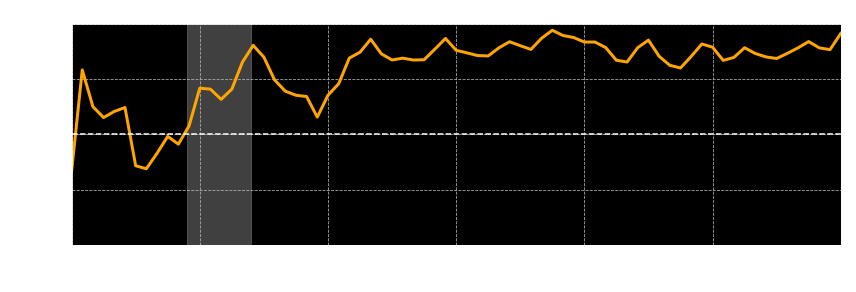

In [218]:
# plot
fig, ax = plt.subplots(figsize=(12,4))
plt.plot(x_values, smoothed_y_values, color='orange', linewidth=3)
plt.axhline(y=0, color='white', linestyle='--')

# make x ticks every 1 minute
plt.xticks(np.arange(0, 11, step=1))

start_point_x = 4 + 54/60
# interpolate the y values at the start point
start_point_y = np.interp(start_point_x, x_values, smoothed_y_values)

end_point_x = 5 + 24/60
# interpolate the y values at the end point
end_point_y = np.interp(end_point_x, x_values, smoothed_y_values)

# plot shaded area between start and end points of x
plt.axvspan(start_point_x, end_point_x, alpha=0.5, color='gray')

plt.ylim(-100, 100)
plt.xlim(4, 10)
plt.xlabel('Game Time (minutes)')
plt.ylabel('Player 1 Win Probability (%)')
# set all background to black
plt.gca().set_facecolor('black')
plt.tight_layout()
plt.show()

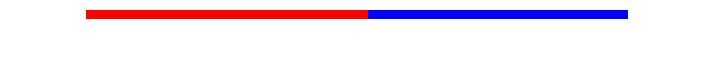

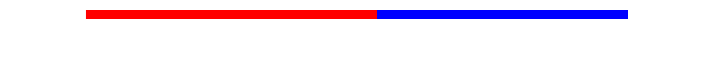

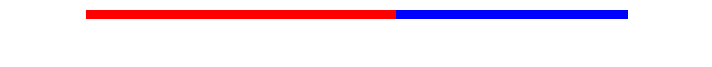

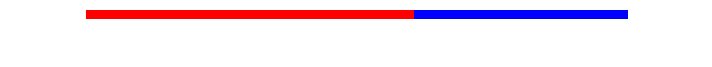

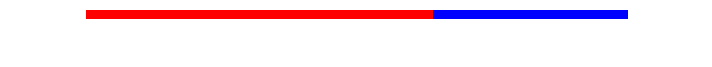

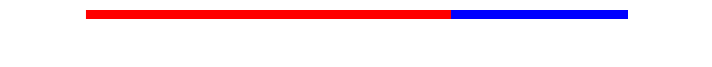

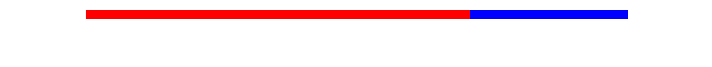

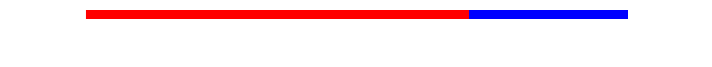

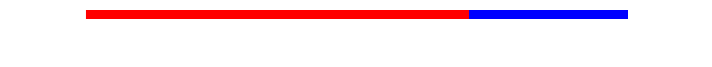

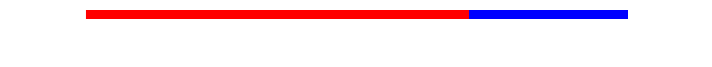

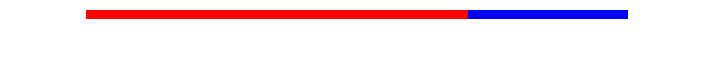

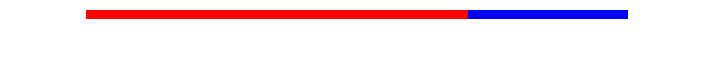

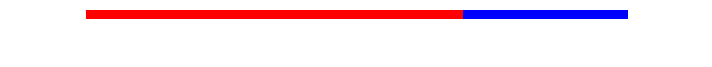

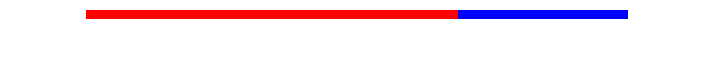

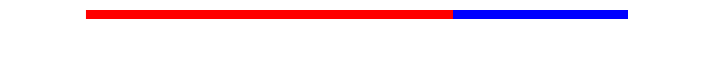

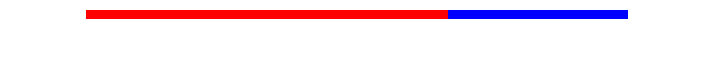

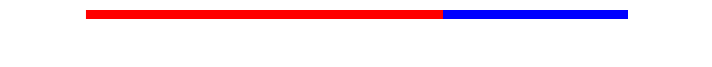

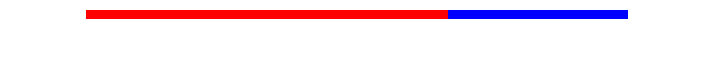

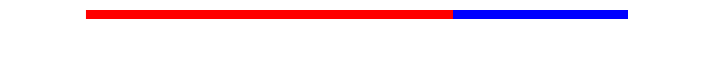

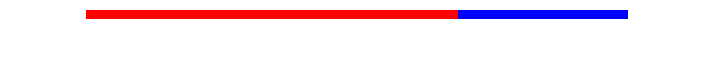

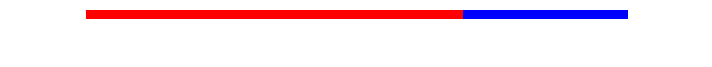

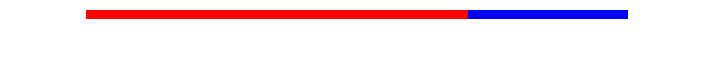

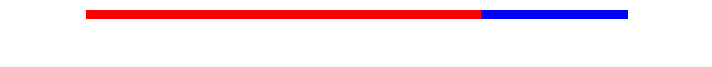

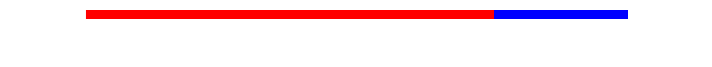

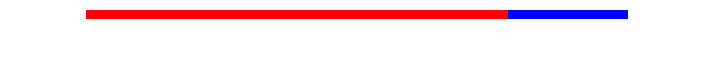

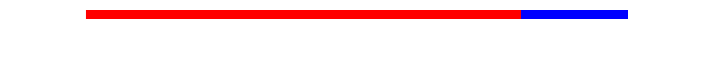

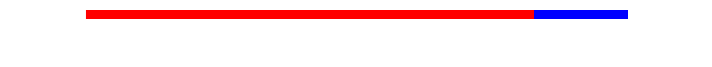

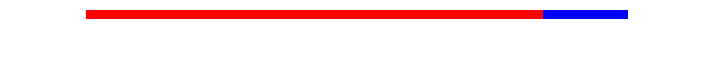

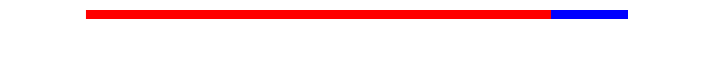

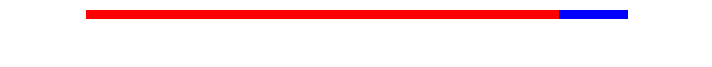

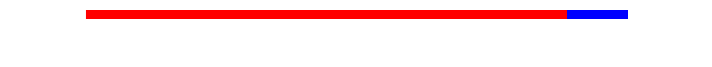

In [209]:
# create array with values every second between start and end points
x_values_array = np.arange(start_point_x, end_point_x + 1/60, step=1/60)

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)
# loop through each value in x_values_array and interpolate the y values
for x_val in x_values_array:
    y_val = np.interp(x_val, x_values, smoothed_y_values)
    
    # plot stacked barh
    # player 1 starts at 100% and player 2 starts where player 1 ends
    fig, ax = plt.subplots(figsize=(10, 1))

    plt.barh(
        y=0,
        width=100+y_val,
        height=1,
        color='red',
        label='Player 1',
        left=-100
    )
    ax.barh(
        y=0,
        width=200 - y_val,
        height=1,
        color='blue',
        label='Player 2',
        left=y_val
    )
    plt.xlim(-100, 100)
    plt.grid(False)
    # plt.grid(axis='x', color='white', linestyle='--')

    # make x ticks absolute values of themselves
    new_xticks = np.arange(100, 0, -25)
    new_xticks = np.concatenate((new_xticks, np.arange(0, 101, 25)))
    # convert x ticks to strings
    new_labels = [str(x) for x in new_xticks]
    # set x ticks and labels
    plt.xticks(np.arange(-100, 101, 25), new_xticks)

    # set y label and rotate it
    h = plt.ylabel('Player 1')
    h.set_rotation(0)
    h.set_horizontalalignment('right')
    h.set_verticalalignment('center')
    # remove the y ticks
    ax.set_yticks([])

    # plot secondary y label
    ax2 = ax.twinx()
    h = ax2.set_ylabel('Player 2')
    h.set_rotation(0)
    h.set_horizontalalignment('left')
    h.set_verticalalignment('center')
    ax2.set_yticks([])

    ax.set_xlabel('Victory Probability (%)')

    # make background transparent
    fig.patch.set_visible(False)

    plt.tight_layout()
    # save as png
    save_path = 'C:/Users/jared/Desktop/predictions/'+str(x_val)+'.png'
    plt.savefig(save_path, transparent=True)




In [175]:
new_xticks

array([100,  75,  50,  25,   0,  25,  50,  75])

In [113]:
# save data to csv
agg_predictions.to_csv('data/new_agg_predictions.csv')



In [114]:
prediction_results.to_csv('data/ensemble_prediction_results.csv')